In [2]:
%load_ext autoreload
%autoreload 2
import pyro
import math
import pyro.distributions as dist
import pyro.optim as optim
import pyro.infer as infer
import torch
import torchsde
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyro.infer.autoguide import (
    AutoMultivariateNormal,
    AutoDiagonalNormal,
    AutoIAFNormal,
    AutoDelta,
    AutoLowRankMultivariateNormal,
    init_to_mean,
)
from pyro.nn.module import to_pyro_module_
import pyro.poutine as poutine
import pyro.infer.reparam as reparam


def summary(samples):
    # Helper function to get quantiles of an estimate
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(
            percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]
        ).transpose()
        site_stats[site_name] = describe[
            ["mean", "std", "5%", "25%", "50%", "75%", "95%"]
        ]
    return site_stats


In [3]:
# This block loads in SPY data. N_Lags was used in the earlier standard implementation

N_LAGS = 4
df = pd.read_csv("../data/SPY.csv")[["Close"]].apply(np.log).diff().fillna(0)
# data = pd.concat([df.shift(i).add_suffix(f"_{i}") for i in range(N_LAGS+1)], axis=1).dropna()
# data["const"] = 1
data = torch.Tensor(df.Close.values).reshape(-1, 1)


In [22]:
# Generates a specific process, used to check the original implementation

N_LAGS = 1
noise_eps = np.exp(-2.0)

def noise(n_obs):
    jitter = np.random.lognormal(-4, 0.01)
    return np.random.laplace(0, noise_eps, n_obs)

data = noise(N_LAGS).tolist()
means = np.random.normal(0, 0.05, N_LAGS)
sigmas = np.random.lognormal(-3, 0.25, N_LAGS)
means[0] = np.abs(means[0]) + 0.07
# sigmas[0] += 0.01

# Cholesky is for correlations, used only to test the impact/recovery of correlation
# matrices
chol = torch.distributions.LKJCholesky(4, 30.0).sample().numpy() 

cov = chol @ chol.T
sigma_mat = np.eye(N_LAGS) * sigmas
bias = 0.0001

for n in range(10000):
    basis = np.array(data[-N_LAGS:])
    coefs = (np.random.multivariate_normal(means, sigma_mat @ cov @ sigma_mat))[::-1]
    data.append((basis * coefs).sum() + bias + noise(1)[0] + bias)

df = pd.DataFrame({"close":data[-2000:]})
data = pd.concat([df.shift(i).add_suffix(f"_{i}") for i in range(N_LAGS+1)], axis=1).dropna()
# data["const"] = 1
data = torch.Tensor(data.values).reshape(-1, 1)

feats, obs = data[:,1:], data[:,:1]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 1)

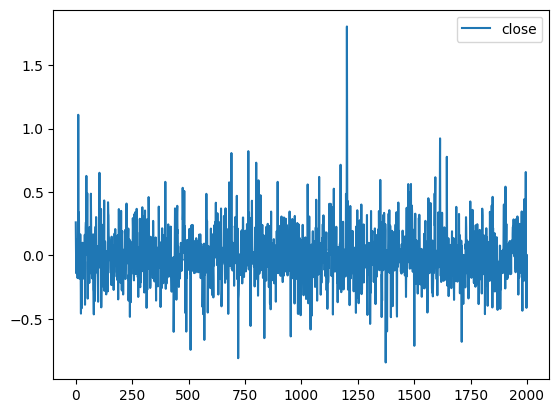

[ 0.13496829  0.03661652  0.06427119 -0.02922295] [0.03946517 0.06279188 0.04039    0.02953807]


In [ ]:
df.plot(); plt.show()
print(means, sigmas)

In [23]:
# Correlation experiment - used to directly model correlation where possible
# Doesn't work super well except to handle the relationship between bias and
# models, as the correlation is in the ERROR term

def vec_to_tril_matrix(vec, diag=0):
    """
    Convert a vector or a batch of vectors into a batched `D x D`
    lower triangular matrix containing elements from the vector in row order.
    """
    # +ve root of D**2 + (1+2*diag)*D - |diag| * (diag+1) - 2*vec.shape[-1] = 0
    n = (
        -(1 + 2 * diag)
        + ((1 + 2 * diag) ** 2 + 8 * vec.shape[-1] + 4 * abs(diag) * (diag + 1)) ** 0.5
    ) / 2
    eps = torch.finfo(vec.dtype).eps
    if not torch._C._get_tracing_state() and (round(n) - n > eps):
        raise ValueError(
            f"The size of last dimension is {vec.shape[-1]} which cannot be expressed as "
            + "the lower triangular part of a square D x D matrix."
        )
    n = torch.round(n).long() if isinstance(n, torch.Tensor) else round(n)
    mat = vec.new_zeros(vec.shape[:-1] + torch.Size((n, n)))
    arange = torch.arange(n, device=vec.device)
    tril_mask = arange < arange.view(-1, 1) + (diag + 1)
    mat[..., tril_mask] = vec
    return mat


def to_corr(input_tensor):
    x = torch.tanh(input_tensor)
    eps = torch.finfo(x.dtype).eps
    x = x.clamp(min=-1 + eps, max=1 - eps)
    r = vec_to_tril_matrix(x, diag=-1)
    z = r**2
    z1m_cumprod_sqrt = (1 - z).sqrt().cumprod(-1)
    # Diagonal elements must be 1.
    r = r + torch.eye(r.shape[-1], dtype=r.dtype, device=r.device)
    return r * torch.nn.functional.pad(z1m_cumprod_sqrt[..., :-1], [1, 0], value=1)

class GarchModel(pyro.nn.PyroModule):
    def __init__(self, p_mu=7, p_sigma=5, q_mu=3, q_sigma=2, ):
        super().__init__()
        self.p_mu, self.p_sigma = p_mu, p_sigma
        self.q_mu, self.q_sigma =  q_mu, q_sigma
        self.n_steps_ar = max(p_mu, q_mu)
        self.n_steps_ch = max(p_sigma, q_sigma)


    def forward(self, data:torch.Tensor):
        num_obs = data.size(0)
        # epsilon = torch.diff(data, dim=0)

        expectation = torch.zeros(num_obs, *data.shape[1:], dtype=data.dtype)
        resid = torch.zeros(num_obs, *data.shape[1:], dtype=data.dtype)
        expectation[: self.n_steps_ar] = data[: self.n_steps_ar]
        resid = expectation[: self.n_steps_ar] = torch.diff(data[: self.n_steps_ar+1], dim=0)
        ar_mu = pyro.sample("ar_mu", dist.Normal(0, 0.5).expand((num_obs-self.n_steps_ar,)).to_event(1))
        ar_a = pyro.sample("ar_a", dist.Normal(0, 0.5).expand((num_obs-self.n_steps_ar, self.p_mu,)).to_event(2))
        ar_b = pyro.sample("ar_b", dist.Normal(0, 0.5).expand((num_obs-self.n_steps_ar, self.q_mu,)).to_event(2))

        for idx in range(self.n_steps_ar, num_obs):
            ar_component = expectation[idx-self.p_mu:idx].T @ ar_a[idx]
            ma_component = resid[idx - self.q_mu:idx].T @ ar_b[idx]
            mu_hat = (ar_mu[idx] + ar_component + ma_component).view(1,-1)
            print(mu_hat.shape, data[idx].shape,(data[idx] - mu_hat).shape)
            expectation[idx], resid[idx] = mu_hat, (data[idx] - mu_hat)
            raise ValueError


        # ch_z = pyro.sample(
        #     "ch_z", dist.Normal(0, 0.5).expand((num_obs, self.n_steps_ar)).to_event(2)
        # )
        # ch_sigma = pyro.sample(
        #     "ch_mu", dist.Normal(0, 0.5).expand((num_obs, self.n_steps_ar)).to_event(2)
        # )

        # ch_epsilon = residuals.sqrt() * ch_z
        
        # expectations[: self.n_steps_ar] = data[: self.n_steps_ar]
        # variances[: self.n_steps_ar] = residuals[: self.n_steps_ar]

        # ar_coef_mean = pyro.sample(
        #     "ar_coed", dist.Normal(0, 0.5).expand((num_obs, self.n_steps_ar)).to_event(2)
        # )

        # noise_scale = pyro.sample("obs_scale", dist.LogNormal(-5.0, 4.0))
        # phi = pyro.sample("ar_phi", dist.Normal(ar_coef_mean, ar_coef_std).to_event(2))

        # for idx in range(num_obs -1):
        #     idx_start_ar = idx - self.n_steps_ar
        #     if idx_start_ar >= 0:
        #         means[idx+1] = (means[idx_start_ar:idx] * phi[idx]).sum()
        # # ar_coef_mat = pyro.sample(
        # #     "ar_corr", dist.LKJCholesky(concentration=2.0, dim=num_steps)
        # # )
        # scale_mat = ar_coef_std * torch.eye(num_steps)
        # corr_scale = ar_coef_mat @ scale_mat
        # phi = pyro.sample(
        #     "ar_phi", dist.MultivariateNormal(ar_coef_mean, scale_tril=corr_scale)
        # )
        return means
        phi = phi.tile((num_obs, 1, 1))

        outputs = torch.bmm(phi, data.unsqueeze(-1)).squeeze(-1)
        with pyro.plate("output", num_obs, dim=-2):
            return pyro.sample(
                "obs",
                dist.Cauchy(
                    # stability=torch.sigmoid(noise_stability) + 1,
                    # skew=torch.tanh(noise_skew),
                    loc=0,
                    scale=noise_scale,
                ),
                obs=obs,
            )

    # def guide(self, data, obs=None):
    #     _, num_steps = data.shape
    #     # Number of parameters needed to parametrise a correlation matrix.
    #     noise_loc = pyro.param("noise_loc", torch.tensor(-3.0))
    #     noise_scale = pyro.param(
    #         "noise_scale", torch.tensor(0.001), constraint=dist.constraints.positive
    #     )
    #     ar_mean_loc = pyro.param("ar_mean_loc", torch.zeros(num_steps))
    #     ar_mean_scale = pyro.param(
    #         "ar_mean_scale",
    #         torch.ones(num_steps) * 0.01,
    #         constraint=dist.constraints.positive,
    #     )
    #     ar_std_loc = pyro.param("ar_std_loc", torch.ones(num_steps) * -3)
    #     ar_std_scale = pyro.param(
    #         "ar_std_scale",
    #         torch.ones(num_steps) * 0.01,
    #         constraint=dist.constraints.positive,
    #     )

    #     ar_coef_mean = pyro.sample(
    #         "ar_mean", dist.Normal(ar_mean_loc, ar_mean_scale).to_event(1)
    #     )
    #     ar_coef_std = pyro.sample(
    #         "ar_std", dist.LogNormal(ar_std_loc, ar_std_scale).to_event(1)
    #     )
    #     pyro.sample("obs_scale", dist.LogNormal(noise_loc, noise_scale))
    #     pyro.sample("ar_phi", dist.Normal(ar_coef_mean, ar_coef_std).to_event(1))

        # q = num_steps * (num_steps - 1) // 2
        # cholesky_params_loc = pyro.param("cholesky_params_loc", torch.zeros(q))
        # cholesky_params_scale = pyro.param(
        #     "cholesky_params_scale",
        #     torch.ones(q) * 0.01,
        #     constraint=dist.constraints.positive,
        # )
        # cholesky_params = pyro.sample(
        #     "cholesky_params",
        #     dist.Normal(cholesky_params_loc, cholesky_params_scale).to_event(1),
        # )
        # ar_coef_mat = pyro.sample(
        #     "ar_corr", dist.Delta(to_corr(cholesky_params)).to_event(2)
        # )
        # scale_mat = ar_coef_std * torch.eye(num_steps)
        # corr_scale = ar_coef_mat @ scale_mat
        # pyro.sample("ar_phi", dist.MultivariateNormal(ar_coef_mean, scale_tril=corr_scale))


In [ ]:
def arma_garch_forward(
    num_obs,
    n_steps_ar,
    n_steps_ch,
    p_mu,
    q_mu,
    p_sigma,
    q_sigma,
    data,
    diffed_inputs,
    ar_mu,
    ar_a,
    ar_b,
    ch_omega,
    ch_alpha,
    ch_beta,
):
    # Seed values
    mu = []
    residual = []
    # Estimate ARMA process
    # for idx in pyro.markov(range(num_obs), n_steps_ar):
    diffed_inputs = diffed_inputs[..., : n_steps_ar + 1, :]
    for idx in range(num_obs):
        if idx < n_steps_ar:
            mu.append(data[..., idx : idx + 1, :])
            residual.append(diffed_inputs[..., idx : idx + 1, :])
            continue
        item = data[..., idx - p_mu : idx, :].detach()
        ar_component = item * ar_a[..., idx, :, :].transpose(-1, -2)
        ar_component = ar_component.mean(dim=-2, keepdim=True)
        local_resid = torch.cat(residual[idx - q_mu : idx], dim=-2)
        ma_component = local_resid * ar_b[..., idx, :, :].transpose(-1, -2)
        ma_component = ma_component.mean(dim=-2, keepdim=True)
        mu_hat = ar_mu[..., idx, :, :].transpose(-1, -2) + ar_component + ma_component
        mu.append(mu_hat)
        residual.append(item[..., -1:, :] - mu_hat)

    # Cat outputs
    mu = torch.cat(tuple(mu), dim=-2)
    residual = torch.cat(tuple(residual), dim=-2)
    resid_sq = residual.pow(2)

    # Init sigma + params
    sigma_sq = []

    # Estimate GARCH process
    # for idx in pyro.markov(range(num_obs), n_steps_ch):
    for idx in range(num_obs):
        if idx < n_steps_ch:
            sigma_sq.append(resid_sq[..., idx : idx + 1, :])
            continue
        item = resid_sq[..., idx - p_sigma : idx, :].detach()
        eps_component = item * ch_alpha[..., idx, :, :].transpose(-1, -2)
        eps_component = eps_component.mean(dim=-2, keepdim=True)
        local_resid = torch.cat(tuple(sigma_sq[idx - q_sigma : idx]), dim=-2)
        vol_component = local_resid * ch_beta[..., idx, :, :].transpose(-1, -2)
        vol_component = vol_component.mean(dim=-2, keepdim=True)
        sigma_sq.append(
            (
                ch_omega[..., idx, :, :].transpose(-1, -2)
                + eps_component
                + vol_component
            ).abs()
        )

    # Cat output
    sigma_sq = torch.cat(tuple(sigma_sq), dim=-2)

    # Constrain params
    sigma = sigma_sq.sqrt() + 1e-7
    latent_z = residual / sigma
    return mu, sigma, latent_z


class GarchModel(pyro.nn.PyroModule):
    def __init__(
        self,
        n_series=1,
        p_mu=7,
        p_sigma=5,
        q_mu=3,
        q_sigma=2,
    ):
        super().__init__()
        self.n_series = n_series
        self.p_mu, self.p_sigma = p_mu, p_sigma
        self.q_mu, self.q_sigma = q_mu, q_sigma
        self.n_steps_ar = max(p_mu, q_mu)
        self.n_steps_ch = max(p_sigma, q_sigma)
        self.n_obs = max(self.n_steps_ar, self.n_steps_ch)

    def forward(self, data: torch.Tensor):
        num_obs = data.size(-2)

        # Sample params
        ar_mu = pyro.sample(
            "ar_mu",
            dist.Normal(0, 0.25).expand((num_obs, self.n_series, 1)).to_event(3),
        )
        ar_a = pyro.sample(
            "ar_a",
            dist.Normal(0, 0.25)
            .expand((num_obs, self.n_series, self.p_mu))
            .to_event(3),
        )
        ar_b = pyro.sample(
            "ar_b",
            dist.Normal(0, 0.25)
            .expand((num_obs, self.n_series, self.q_mu))
            .to_event(3),
        )

        ch_omega = pyro.sample(
            "ch_omega",
            dist.Normal(0, 0.25).expand((num_obs, self.n_series, 1)).to_event(3),
        )
        ch_alpha = pyro.sample(
            "ch_alpha",
            dist.Normal(0, 0.25)
            .expand((num_obs, self.n_series, self.p_sigma))
            .to_event(3),
        )
        ch_beta = pyro.sample(
            "ch_beta",
            dist.Normal(0, 0.25)
            .expand((num_obs, self.n_series, self.q_sigma))
            .to_event(3),
        )
        data_size = list(ar_a.shape[:-3] + data.shape)
        data = data.expand(data_size)
        diffed_inputs = torch.diff(data, dim=-2)
        mu, sigma, latent_z = arma_garch_forward(
            num_obs,
            self.n_steps_ar,
            self.n_steps_ch,
            self.p_mu,
            self.q_mu,
            self.p_sigma,
            self.q_sigma,
            data,
            diffed_inputs,
            ar_mu,
            ar_a,
            ar_b,
            ch_omega,
            ch_alpha,
            ch_beta,
        )
        pyro.sample(
            "ch_z",
            dist.Normal(0, 1).expand((num_obs, self.n_series)).to_event(2),
            obs=latent_z,
        )
        pyro.deterministic("mu", mu)
        pyro.deterministic("sigma", sigma)
        cut = num_obs - self.n_obs
        data_size[-2] = cut
        pyro.sample(
            "obs_center",
            dist.SoftLaplace(mu[..., -cut:, :], 0.01)
            .expand(data_size)
            .to_event(2),
            obs=data[..., -cut:, :],
        )
        pyro.sample(
            "vol_center",
            dist.SoftLaplace(sigma[..., -cut:, :], 0.01)
            .expand(data_size)
            .to_event(2),
            obs=diffed_inputs[..., -cut:, :].abs(),
        )
        return pyro.sample(
            "obs",
            dist.SoftLaplace(mu[..., -cut:, :], sigma[..., -cut:, :])
            .expand(data_size)
            .to_event(2),
            obs=data[..., -cut:, :],
        )

class NNet(torch.nn.Module):
    def __init__(self, n_in, n_out, n_hidden=32):
        super().__init__()
        self.lin = torch.nn.Linear(n_in, n_out)
        self.nlin1 = torch.nn.Linear(n_in, n_hidden)
        self.nlin2 = torch.nn.Linear(n_hidden, n_hidden)
        self.nlin3 = torch.nn.Linear(n_hidden, n_out)
        self.act = torch.nn.ReLU()
        
    def forward(self, x):
        # nonlin_part = self.act(self.nlin3(self.act(self.nlin1(x))))
        nonlin_part = self.nlin3(self.act(self.nlin2(self.act(self.nlin1(x)))))
        return nonlin_part
        lin_part = self.lin(x)
        return (lin_part + nonlin_part) #* (self.scale.exp() + 1e-7)


class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "stratonovich"

    def __init__(self, state_size):
        super().__init__()
        self.mu = NNet(state_size + 1, state_size)
        # self.sigma = torch.nn.Linear(state_size,
        #                              state_size * brownian_size)
        self.sigma = NNet(state_size+ 1, state_size)
        # self.mean_scale = torch.nn.Parameter(torch.tensor(-2.0), True)
        self.std_scale = torch.nn.Parameter(torch.tensor(-3.0), True)
        # self.mu.weight.data *=
        # self.sigma.weight.data *= 0.001

    # Drift
    def f(self, t, y):
        scale_down = y.abs()
        # return self.mu(self.join_obs(y, t))# * self.mean_scale.exp()
        return -(torch.sign(y) * scale_down) + self.mu(self.join_obs(y, t))
        # return  -torch.sign(y) * self.mu(torch.tanh(y)) **2  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        base_std = self.sigma(self.join_obs(y, t))
        return (base_std).exp()

    def join_obs(self, y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return torch.cat((y, t[None, None].tile(y.size(0), 1)), dim=-1)

def format_sample(tensor: torch.Tensor, shape: torch.Size): 
    shape = [tensor.size(0)] + shape + [-1, tensor.size(-1)]
    return tensor.reshape(shape).transpose(0, -3)

class GarchGuide(pyro.nn.PyroModule):
    def __init__(
        self,
        n_series=1,
        p_mu=7,
        p_sigma=5,
        q_mu=3,
        q_sigma=2,
    ):
        super().__init__()
        self.n_series = n_series
        self.p_mu, self.p_sigma = p_mu, p_sigma
        self.q_mu, self.q_sigma = q_mu, q_sigma
        self.n_steps_ar = max(p_mu, q_mu)
        self.n_steps_ch = max(p_sigma, q_sigma)
        self.n_obs = max(self.n_steps_ar, self.n_steps_ch)
        self.state_size = self.p_mu + self.q_mu + self.p_sigma + self.q_sigma + 2
        # self.y0 = pyro.param("y_0", torch.zeros(n_series, self.state_size))
        # I don't know if I should have made this a pyroparam but I assume it makes no
        # difference...pyroparams are just nnparams with some extra functionality
        self.y0 = torch.nn.Parameter(torch.randn(n_series, self.state_size) * 0.00001, True)
        self.y0_noise_scale = torch.nn.Parameter(torch.tensor(-5.0), True)
        self.sde = pyro.nn.PyroModule[SDE](self.state_size)
        # self.param_map = pyro.nn.PyroModule[NNet](1, self.state_size)

    def forward(self, data: torch.Tensor):
        plate_sizes = [
            item.size
            for item in poutine.runtime._PYRO_STACK
            if isinstance(item, pyro.plate)
        ]
        num_obs = data.size(-2)
        num_repeats = math.prod(plate_sizes)
        ts = torch.linspace(0, 1, num_obs)
        batched_y0 = self.y0.tile([num_repeats, 1])
        # Jitter the start location
        noise = torch.randn(batched_y0.shape) * (self.y0_noise_scale.exp() + 1e-7)
        batched_y0 = batched_y0 + noise
        # params will have shape (t_size, batch_size, state_size)
        params = torchsde.sdeint_adjoint(self.sde, batched_y0, ts, method="reversible_heun") #* self.y0_noise_scale.exp()
        
        # Uncomment param_map to use a raw nnet (non-stochastic), or y0 to just use a
        # deterministic single set of params
        # params = self.param_map(ts[...,None])[...,None,:].tile([1,num_repeats,1])
        # params = self.y0[ None].tile([num_obs, num_repeats, 1])
        ar_mu, ar_a, ar_b, ch_omega, ch_alpha, ch_beta = torch.split(
            params, [1, self.p_mu, self.q_mu, 1, self.p_sigma, self.q_sigma], dim=-1
        )
        pyro.sample("ar_mu", dist.Delta(format_sample(ar_mu, plate_sizes)).to_event(3))
        pyro.sample("ar_a", dist.Delta(format_sample(ar_a, plate_sizes)).to_event(3))
        pyro.sample("ar_b", dist.Delta(format_sample(ar_b, plate_sizes)).to_event(3))
        pyro.sample("ch_omega", dist.Delta(format_sample(ch_omega, plate_sizes)).to_event(3))
        pyro.sample("ch_alpha", dist.Delta(format_sample(ch_alpha, plate_sizes)).to_event(3))
        pyro.sample("ch_beta", dist.Delta(format_sample(ch_beta,plate_sizes)).to_event(3))



pyro.clear_param_store()
model = GarchModel()
guide = GarchGuide()
# for _ in range(1):
check_data = data[:70].reshape(-1, 1).tile(1, 13)
out = model(check_data)
out2 = guide(check_data)
# # (torch.randn(3,2) * torch.randn(3,2)).sum(dim=0, keepdims=True).shape
# # data.diff()
# out


d:\projects\sadana\experiments\continuous-garch\.venv\lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at ch_z
  warnings.warn(
d:\projects\sadana\experiments\continuous-garch\.venv\lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs_center
  warnings.warn(
d:\projects\sadana\experiments\continuous-garch\.venv\lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at vol_center
  warnings.warn(
d:\projects\sadana\experiments\continuous-garch\.venv\lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs
  warnings.warn(
d:\projects\sadana\experiments\continuous-garch\.venv\lib\site-packages\torchsde\_core\adjoint.py:253: UserWarning: The spacing between time points `ts` is not an integer multiple of the time step `dt`. This means that the backward pass (which is forced

In [ ]:
pyro.clear_param_store()
model_params = (1, 14, 7, 7, 3)
model = GarchModel(*model_params)
guide = GarchGuide(*model_params)
# torch.autograd.set_detect_anomaly(True)
# feats, obs = data[:,1:], data[:,:1]
# guide = AutoDiagonalNormal(
#     model,
#     # init_scale=0.001,
#     init_scale=0.0001,
#     init_loc_fn=pyro.infer.autoguide.init_to_mean,
# )
# model(data)
# guide(data)
# pyro.get_param_store()["AutoDiagonalNormal.loc"].data.fill_(0.0) 
# = torch.randn(
#     *pyro.get_param_store()["AutoDiagonalNormal.loc"].size()
# ) * 0.0001
# guide = AutoDelta(model)
# setup the optimizer and the inference algorithm
optimizer = optim.ClippedAdam({"lr": 1e-2, "betas": (0.99, 0.999)})
# svi = infer.SVI(model, guide, optimizer, loss=infer.JitTraceMeanField_ELBO(num_particles=1, max_plate_nesting=1))#, vectorize_particles=True))
svi = infer.SVI(
    model,
    guide,
    optimizer,
    loss=infer.TraceGraph_ELBO(
        num_particles=16, vectorize_particles=True
        ),
)
check_data = data
for i in range(2000):
    elbo = svi.step(check_data)
    if i % 5 == 0:
        print("Epoch: {}  Elbo loss: {}".format(i, elbo / check_data.shape[0]))


Epoch: 0  Elbo loss: 165.02803535207187
Epoch: 5  Elbo loss: 157.0705773688786
Epoch: 10  Elbo loss: 152.48614532019704
Epoch: 15  Elbo loss: 150.11937662996232
Epoch: 20  Elbo loss: 130.89170711388005
Epoch: 25  Elbo loss: 121.45189800057955
Epoch: 30  Elbo loss: 113.57075847580411
Epoch: 35  Elbo loss: 106.23178969863808
Epoch: 40  Elbo loss: 107.58499348015069
Epoch: 45  Elbo loss: 89.232704288612
Epoch: 50  Elbo loss: 63.44300565053608
Epoch: 55  Elbo loss: 50.97847091422776
Epoch: 60  Elbo loss: 44.69286076499565
Epoch: 65  Elbo loss: 38.34133675021733
Epoch: 70  Elbo loss: 26.360638220805562
Epoch: 75  Elbo loss: 15.788696890394089
Epoch: 80  Elbo loss: 3.8683564886083746
Epoch: 85  Elbo loss: -2.3117503871160534
Epoch: 90  Elbo loss: -6.4291509707331205
Epoch: 95  Elbo loss: -8.268272556867574
Epoch: 100  Elbo loss: -11.867201083019415
Epoch: 105  Elbo loss: -8.369631877535497
Epoch: 110  Elbo loss: -5.150838298681542
Epoch: 115  Elbo loss: -3.5166355200485366
Epoch: 120  Elbo l

KeyboardInterrupt: 

In [ ]:
# out
print(i, elbo / check_data.shape[0])
num_samples=200
predictive = infer.Predictive(model, guide=guide, num_samples=num_samples, parallel=True)
samples = predictive(check_data)

# pyro.sample

601 -6.578636627064619


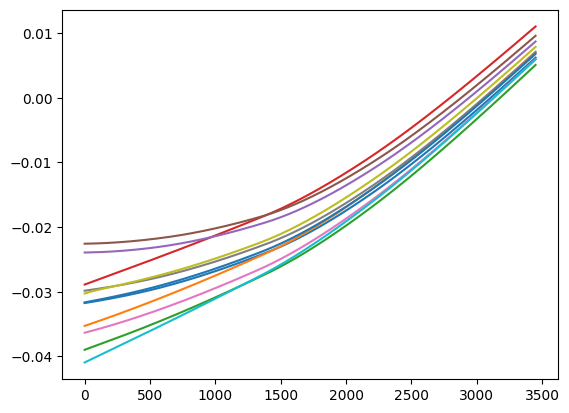

In [ ]:
checking = samples["ar_a"][...,-1].squeeze()
for idx in range(10):
    plt.plot(checking[idx])
plt.plot(checking.mean(dim=0))
# samples["init_values"]

In [ ]:
# Basic garch
n_test = 1200

for n in range(1):
    phi_unbound =dist.Normal(0, 1.0).expand((n_test,)).sample()
    # h_sigma = dist.StudentT(1, 0, 0.35).expand((n_test,)).sample()
    h_sigma = dist.Cauchy(0,0.5).expand((n_test,)).sample()
    mu = dist.SoftLaplace(0, 0.005).expand((n_test,)).sample()
    h_std = dist.SoftLaplace(0, 0.005).expand((n_test,)).sample()
    # h_std = 0.15
    mu = -4

    phi = torch.tanh(phi_unbound)
    h_tx = h_sigma * h_std
    h_tx_orig = h_tx.numpy().copy()
    h_tx[0] /= torch.sqrt(1-phi[0] **2) + 1e-7
    for idx in range(1, len(h_tx)):
        h_tx[idx] += phi[idx] * (h_tx[idx - 1] )
    h_tx += mu
    y = dist.Normal(torch.zeros(n_test), 1.0).sample() * torch.exp(h_tx/2)


In [ ]:
pyro.ops.tensor_utils.periodic_features

<function pyro.ops.tensor_utils.periodic_features(duration, max_period=None, min_period=None, **options)>

In [ ]:
torch.pow(y, 0.12321)

tensor([   nan,    nan,    nan,  ..., 0.6155,    nan,    nan])

0.11647672


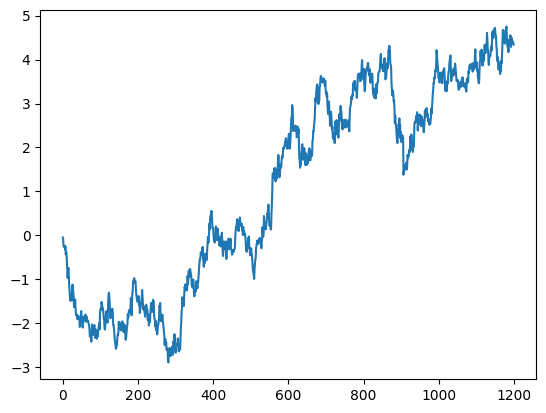

In [ ]:
out = pd.Series(y.numpy())
# plt.plot(np.cumsum(out))
plt.plot(out.cumsum())
print(out[out.abs()< out.abs().quantile(0.95)].std())
# plt.plot(h_tx_orig)
# plt.ylim(-20,20)

In [ ]:
print(pyro.get_param_store().keys())
# print(noise_eps)
print(pyro.get_param_store()["noise_scale"])
# print(to_corr(pyro.get_param_store()["cholesky_params"]))

dict_keys(['stability_loc', 'stability_scale', 'skew_loc', 'skew_scale', 'noise_loc', 'noise_scale', 'ar_mean_loc', 'ar_mean_scale', 'ar_std_loc', 'ar_std_scale', 'ar_mean_centered', 'ar_std_base_centered', 'obs_stability_centered', 'obs_skew_centered', 'obs_scale_base_centered', 'ar_phi_centered'])
tensor(0.0002, grad_fn=<AddBackward0>)


In [ ]:
num_samples=2000
predictive = infer.Predictive(model, guide=guide, num_samples=num_samples)
samples = predictive(feats, obs)
svi_samples = {f"col_{idx}": samples["ar_phi"][...,idx].reshape(num_samples).detach().cpu().numpy()
               for idx in range(feats.size(1))}

# for site, values in summary(svi_samples).items():
#     print("Site: {}".format(site))
#     print(values, "\n")
summaries = summary(svi_samples)
keys = list(summaries.keys())
# [summaries[item].loc[0] for item in keys]
outputs_df = pd.DataFrame([summaries[item].loc[0] for item in keys], index=keys)

In [ ]:
# outputs_df["true_mean"] = means.tolist() + [bias]
# outputs_df["true_std"] = sigmas.tolist() + [0]
outputs_df

mean       std        5%       25%       50%       75%       95%
col_0  0.066317  0.002732  0.061922  0.064472  0.066317  0.068166  0.070887
col_1  0.049346  0.001503  0.046907  0.048363  0.049315  0.050348  0.051842
col_2 -0.021750  0.001444 -0.024141 -0.022730 -0.021675 -0.020779 -0.019507
col_3  0.025437  0.002651  0.021206  0.023605  0.025420  0.027195  0.029716
col_4 -0.001215  0.000044 -0.001289 -0.001244 -0.001215 -0.001186 -0.001144

In [ ]:
sigmas,outputs_df["std"].values

(array([0.07302942, 0.05086455, 0.05293431, 0.05441312]),
 array([0.01504992, 0.01400487, 0.01305678, 0.0128873 , 0.00054194]))

In [ ]:
np.set_printoptions(suppress=True)
corr_est = samples["ar_corr"].squeeze().mean(dim=0).numpy()
print(corr_est)
print(corr_est @ corr_est.T)
print(chol @ chol.T)
print(abs((chol @ chol.T) - (corr_est @ corr_est.T)[:N_LAGS,:N_LAGS]))

[[ 1.          0.          0.          0.          0.        ]
 [ 0.01449479  0.9972206   0.          0.          0.        ]
 [ 0.00991328 -0.01033728  0.9930641   0.          0.        ]
 [-0.01805509  0.02469421 -0.05147205  0.98628783  0.        ]
 [ 0.0062294   0.00176092 -0.008647    0.00153426  0.9999098 ]]
[[ 1.          0.01449479  0.00991328 -0.01805509  0.0062294 ]
 [ 0.01449479  0.99465895 -0.01016486  0.02436387  0.00184632]
 [ 0.00991328 -0.01016486  0.9863815  -0.0515493  -0.00854347]
 [-0.01805509  0.02436387 -0.0515493   0.9763489   0.00188932]
 [ 0.0062294   0.00184632 -0.00854347  0.00188932  0.99993867]]
[[ 1.          0.09117083  0.189884   -0.15085997]
 [ 0.09117083  1.0000001   0.1367342  -0.1459037 ]
 [ 0.189884    0.1367342   1.0000001  -0.20629857]
 [-0.15085997 -0.1459037  -0.20629857  0.99999994]]
[[0.         0.07667605 0.17997073 0.13280487]
 [0.07667605 0.00534117 0.14689906 0.17026758]
 [0.17997073 0.14689906 0.01361865 0.15474927]
 [0.13280487 0.1702675

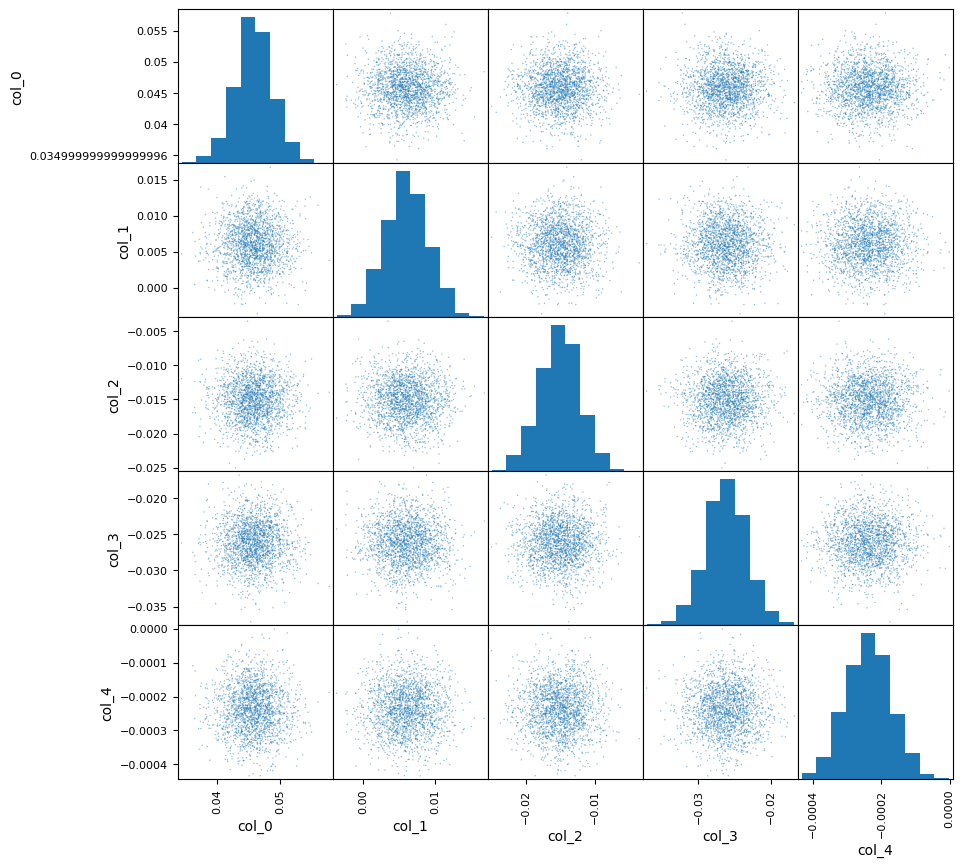

In [ ]:
# plt.scatter(svi_samples["col_0"], svi_samples["col_7"],)
# plt.imshow(pd.DataFrame(svi_samples).corr(method="spearman").abs(),vmin=0, vmax=0.5)
pd.plotting.scatter_matrix(pd.DataFrame(svi_samples), figsize=(10,10), s=4); plt.show()
# pd.DataFrame(svi_samples).iloc[:,:-1].plot.kde(); plt.show()

In [ ]:
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

const = []
def fit_params(data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = arch_model(
            y=data,
            mean="HAR",
            vol="HARCH",
            p=2,
            q=2,
            o=2,
            dist="ged",
            rescale=False,
            lags=21,
            power=2
        )
        res = model.fit(disp="off")
    const.append(res.params)
    return 0

df = pd.read_csv("../data/SPY.csv")[["Close"]].apply(np.log).diff().fillna(0)

sample = df.copy()
data = sample.Close.apply(np.log).diff().fillna(0)
# data = sample.Close.pct_change().fillna(0)

data.rolling(2*49,step=7).apply(fit_params, raw=False)

d:\projects\sadana\experiments\continuous-garch\.venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
d:\projects\sadana\experiments\continuous-garch\.venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
d:\projects\sadana\experiments\continuous-garch\.venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
d:\projects\sadana\experiments\continuous-garch\.venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for 

0       NaN
7       NaN
14      NaN
21      NaN
28      NaN
       ... 
3416    0.0
3423    0.0
3430    0.0
3437    0.0
3444    0.0
Name: Close, Length: 493, dtype: float64

In [ ]:
prm = const[1]

params = pd.concat(const, axis=1).T.reset_index(drop=True)

In [ ]:
import torch
def make_irregular_sine_data():
    ts_ = np.sort(np.random.uniform(low=0.4, high=1.6, size=16))
    ts_ext_ = np.array([0.] + list(ts_) + [2.0])
    ts_vis_ = np.linspace(0., 2.0, 300)
    ys_ = np.sin(ts_ * (2. * np.pi))[:, None] * 0.8

    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float()
    return ts

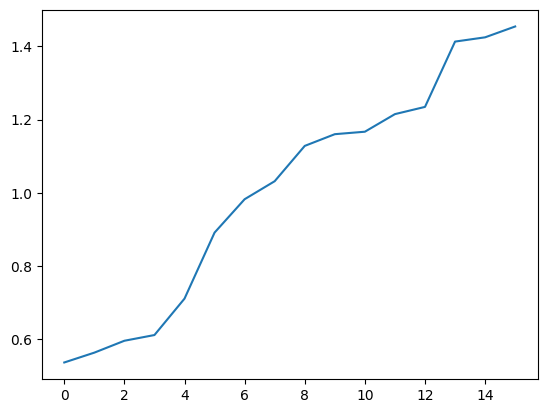

In [ ]:
plt.plot(make_irregular_sine_data())

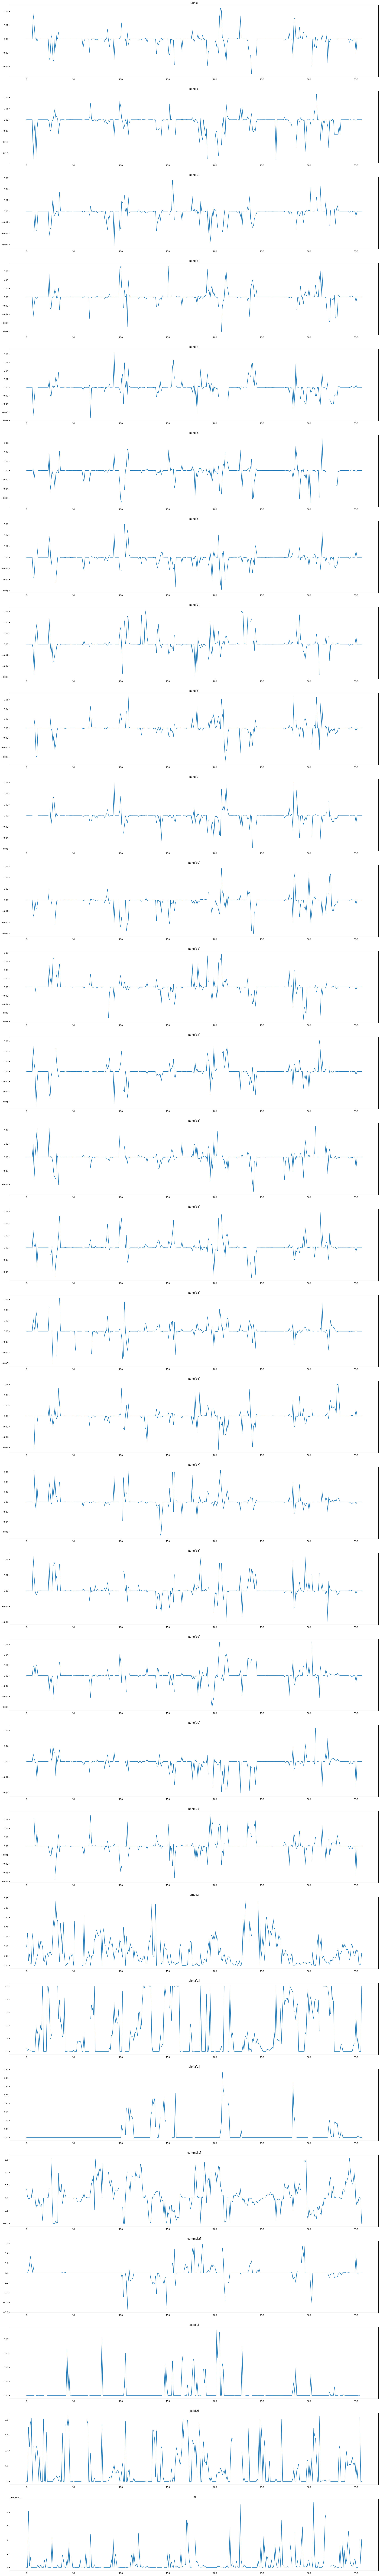

In [ ]:
fig, ax = plt.subplots(len(params.columns), 1, figsize=(30, 7*len(params.columns)))
for n, col in enumerate(params):
    # ax[n].axhline(0, c='C3')
    temp =params[col].copy()
    temp[temp.abs()>temp.abs().quantile(0.95)] = np.nan
    temp.plot(title=col, ax=ax[n])
    # params[col].mul(1.1).plot(ax=ax[n], alpha=0.5)
    # params[col].mul(0.9).plot(ax=ax[n], alpha=0.5)
plt.show()
# params.to_csv("garch_params_30D_16t_norm.csv")

In [ ]:
import torch
import torchsde

batch_size, state_size, brownian_size = 32, 3, 2
t_size = 20

class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self):
        super().__init__()
        self.mu = torch.nn.Linear(state_size, 
                                  state_size)
        self.sigma = torch.nn.Linear(state_size, 
                                     state_size * brownian_size)

    # Drift
    def f(self, t, y):
        return self.mu(y)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma(y).view(batch_size, 
                                  state_size, 
                                  brownian_size)

sde = SDE()
y0 = torch.full((batch_size, state_size),1.0)
ts = torch.linspace(0, 1, t_size)
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, y0, ts)
plt.plot(ys[:,0].detach().numpy())

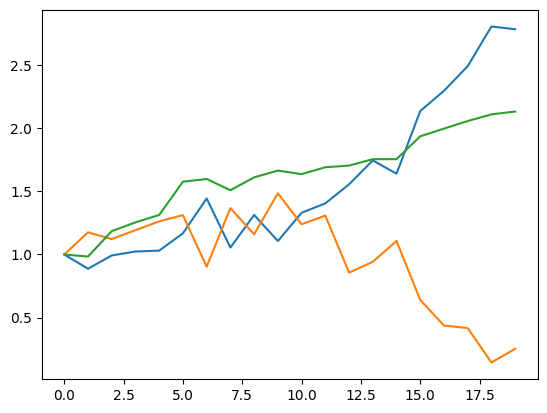